## Some generic functions and classes

In [1]:
from math import pi, sqrt

def deg2rad(deg):
    return (deg/180.0)*pi

def rad2deg(rad):
    return (rad/pi)*180

def posrad(rad):
    while rad<0:
        rad += 2*pi
    while rad>2*pi:
        rad -= 2*pi
    return(rad)

def rad2hour(rad):
    return (posrad(rad)/2/pi)*24

# Compute overlapping interval of two intervals (in radians). Seems to work, but probably the wrong approach 
# ends up being really complicated later

def intervalOverlap(rise1, rise2):
    # If source never rises at either antenna, it won't rise for baseline
    if rise1[0]==None or rise2[0]==None: 
        return([None, None])
    
    # Do the interval comparision - complicated because of 24hr (2wrapping
    if rise1[0]<rise1[1] and rise2[0]<rise2[1]: # Non-wrapped case
        if rise1[1]<rise2[0] or rise2[1]<rise1[0]:
            return([None, None])
        else: # They must overlap
            return([max(rise1[0],rise2[0]), min(rise1[1],rise2[1])])

    elif rise1[0]>rise1[1] and rise2[0]<rise2[1]: # Ant1 wrapped, Ant2 not
        if rise2[0]>rise1[1] and rise2[1]<rise1[0]: # No overlap
            return([None, None])
        elif rise2[0]<rise1[1]:
            if rise2[1]<rise1[0]:
                return([rise2[0], rise1[1]])
            else: 
                return([rise2[0], rise1[1], rise1[0], rise2[1]]) # Not entirely sure this case is correct
        else: # Only one possibility left
            return([rise1[0], rise2[1]])
        
    elif rise2[0]>rise2[1] and rise1[0]<rise1[1]: # Ant2 wrapped, Ant1 not
        if rise1[0]>rise2[1] and rise1[1]<rise2[0]: # No overlap
            return([None, None])
        elif rise1[0]<rise2[1]:
            if rise1[1]<rise2[0]:
                return([rise1[0], rise2[1]])
            else: 
                return([rise1[0], rise2[1], rise2[0], rise1[1]]) # Not entirely sure this case is correct
        else: # Only one possibility left
            return([rise2[0], rise1[1]])

    else:  # Both antenna wrapped
        if rise2[0] < rise1[1] and rise2[1] < rise1[1]:
            return([rise2[0],rise1[1],rise1[0],rise2[1]])
        elif rise2[1] > rise1[0] and rise2[0] < rise1[0]:
            return([rise1[0],rise2[1],rise2[0],rise1[1]])
        else: 
            return([max(rise1[0],rise2[0]), min(rise1[1],rise2[1])])

        
class Cartesian:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    def length(self):
        return sqrt(self.x**2 + self.y**2 + self.z**2)

### Simple Class for a Telescope

In [12]:
from math import pi, cos, sin, acos, asin, atan2, floor

class Telescope:
    def __init__(self, name, longitude, latitude, el_limit, SEFD):
            
        self.name = name
        self.longitude = deg2rad(longitude)
        self.latitude = deg2rad(latitude)
        self.el_limit = deg2rad(el_limit)
        self.sefd = SEFD # Jy
        self.maxBandwidth = 128 * 1e6 # MHz
        self.rise = None
        self.set = None
        
    def __str__(self):
        return "{0}: {1:.1f} {2:.2f} {3:.1f}".format(
            self.name, rad2deg(self.longitude), rad2deg(self.latitude), rad2deg(self.el_limit))

    # Calculate the rise and set time for the source, and set the class "rise" and "set" values in the object
    def calcrise(self, ra, dec): # Return GST rise and set for a source
        z_limit = pi/2-self.el_limit; # Zenith limit

        # Does the source ever rises 
        z = acos(sin(self.latitude)*sin(dec) + cos(self.latitude)*cos(dec)) # Highest point
        if (z > z_limit): 
            self.rise = None
            self.set = None
            return
        
        # or is circumpolar
        z = acos(sin(self.latitude)*sin(dec) - cos(self.latitude)*cos(dec)) # Lowest point
        if (z<z_limit): 
            self.rise = 0
            self.set = 2*pi
            return

        ha = acos((cos(z_limit) - sin(self.latitude)*sin(dec))/(cos(self.latitude)*cos(dec)))
        self.rise = posrad(ra-ha-self.longitude)
        self.set= posrad(ra+ha-self.longitude)
        
    # Is the source  up for the given GST (rise time must have been previously set with calcrise)
    def isUp(self, gst):
        if self.rise==None: return None

        if self.rise<self.set: # Non-wrapped case
            if gst>self.rise and gst<self.set:
                return True
            else:
                return False
        elif gst<self.set or gst>self.rise: # Wrapped case
            return True
        else: 
            return False
        
    # Return a list of times when the source is above the elevation limit, with a fixed step size
    def upTimes(self, RA, Dec, step):
        # RA     Radians
        # Dec    Radians
        # step   Step size for GST time calculation *in radians*
        
        allgst = [x*step for x in range(floor(2*pi/step))]
        self.calcrise(RA, Dec)
        return [gst for gst in allgst if (self.isUp(gst))]

    # Return the 3D cartesian posiiton of the telescope, in m
    def getCartesian(self):
        R_EARTH = 6378.137e3
        phi = pi/2 - self.latitude

        x = R_EARTH * sin(phi) * cos(self.longitude)
        y = R_EARTH * sin(phi) * sin(self.longitude)
        z = R_EARTH * cos(phi)

        return (Cartesian(x,y,z))
    
    # Returns the AzEl of a source at (RA, Dec) , given the passed GST
    def AzEl(self, RA, Dec, gst): 
        lst = posrad(gst + self.longitude)
        ha = posrad(lst-RA)
        sphi = sin(self.latitude)
        cphi = cos(self.latitude)
        sha = sin(ha)
        cha = cos(ha)
        sdec = sin(Dec)
        cdec = cos(Dec)
        az = atan2(-sha,-cha*sphi+sdec*cphi/cdec)
        el= asin(cha*cdec*cphi + sdec*sphi)
        
        return(az, el)
    
    # Return two Lists (Az and El) values, for the given set of GST values (passed as a list)
    def calcAzEl(self, RA, Dec, gsts):
        Az = []
        El = []
        for gst in gsts:
            (Az1, El1) = self.AzEl(RA, Dec, gst)
            Az.append(Az1)
            El.append(El1)
        return(Az, El)

### Simple Class for Baseline

In [13]:
class Baseline:
    C = 299792458;
    
    def __init__(self, ant1, ant2):
        self.ant1 = ant1
        self.ant2 = ant2

        self.name = ant1.name+"->"+ant2.name
        self.xyz1 = ant1.getCartesian()
        self.xyz2 = ant2.getCartesian()
        self.baseline = Cartesian(self.xyz1.x-self.xyz2.x,self.xyz1.y-self.xyz2.y,self.xyz1.z-self.xyz2.z)
        self.length = self.baseline.length()
        self.gsts = None # List of times souce is up on this baseline
        self.u = None
        self.v = None
        
    # Calculate times when source is visible to both telescopes. Set object .gst value for later functions to use
    def calcUp(self, RA, Dec, step):
        self.ant1.calcrise(RA, Dec)
        self.ant2.calcrise(RA, Dec)
        
        allgst = [x*step for x in range(floor(2*pi/step))] # 24 hours
        self.gst = np.array([gst for gst in allgst if (self.ant1.isUp(gst) and self.ant2.isUp(gst))])
        
    def uv(self, RA, Dec, gst, wavelength):
        ha = gst + self.ant1.longitude - RA

        ha = RA - gst  # This calculation of Baseline hour angle needs to be checked
        sHa = sin(ha)
        cHa = cos(ha)

        sDec = sin(Dec)
        cDec = cos(Dec)

        u = (-self.baseline.x*sHa + self.baseline.y*cHa)/wavelength
        v = (-self.baseline.x*cHa*sDec - self.baseline.y*sHa*sDec + self.baseline.z*cDec)/wavelength
    
        return(u,v)
    
    def delay(self, RA, Dec, gst, wavelength):
        ha = gst + self.ant1.longitude - RA

        ha = RA - gst  # This calculation of Baseline hour angle needs to be checked
        sHa = sin(ha)
        cHa = cos(ha)
        sDec = sin(Dec)
        cDec = cos(Dec)
        
        d = self.baseline.x*cHa*cDec + self.baseline.y*sHa*cDec + self.baseline.z*sDec

        return(d/self.C)
    
    
    # Calculate the UV values and set the object .u and .v values for the last set of GSTS
    def UVtrack(self, RA, Dec, gsts, wavelength):
        u = []
        v = []
        for gst in gsts:
            (thisu, thisv) = self.uv(RA, Dec, gst, wavelength)
            u.append(thisu)
            v.append(thisv)
            
        self.u = np.array(u)
        self.v = np.array(v)
    
    def sensitivity(self, integration, bandwidth, dualpol):
        if (dualpol):
            polfact = 2
        else:
            polfact = 1

        bandwidth = min(bandwidth, self.ant1.maxBandwidth, self.ant2.maxBandwidth)
        return sqrt(self.ant1.sefd * self.ant2.sefd) / (0.88*sqrt(polfact*bandwidth*integration))


### Initialise arrays etc

In [14]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

antennas = []
antennas.append(Telescope("ATCA",149.57,-30.31,12,39))
antennas.append(Telescope("Mopra",149.07,-31.3,12,430))
antennas.append(Telescope("Parkes",148.26,-33,30,43))
antennas.append(Telescope("Hobart",147.44,-42.8,16,560))
antennas.append(Telescope("Ceduna",133.81,-31.87,10,600))


Dec = deg2rad(-30)
RA = deg2rad(0) # This actually should make no difference at all
step = 1  # Inverval for calculations, in minutes
freq = 8400; # MHz
bandwidth = 64 # MHz
calInt = 60 # Seconds

step /= (60*24)  # Convert to radians
step *= 2*pi
freq *= 1e6;
bandwidth *= 1e6

wavelength = 2.99792458e8/freq

### Create baselines

In [15]:
baselines = []
for i in range(len(antennas)):
    for j in range(i+1, len(antennas)):
        baselines.append(Baseline(antennas[i], antennas[j]))

### For each antenna calculate rise set 

In [16]:
for ant in antennas:
    ant.calcrise(RA,Dec)
    print(ant.name, ': ', rad2hour(ant.rise+ant.longitude), ' - ', rad2hour(ant.set+ant.longitude))

ATCA :  17.772886646434376  -  6.227113353565625
Mopra :  17.732147030560004  -  6.267852969439996
Parkes :  19.21792085535018  -  4.782079144649818
Hobart :  17.614123493632228  -  6.385876506367769
Ceduna :  17.529579372908337  -  6.470420627091663


### Baseline lengths

In [17]:
for b in baselines:
    print('{0} {1:.0f} km'.format(b.name, b.length/1000))

ATCA->Mopra 120 km
ATCA->Parkes 324 km
ATCA->Hobart 1400 km
ATCA->Ceduna 1508 km
Mopra->Parkes 204 km
Mopra->Hobart 1286 km
Mopra->Ceduna 1444 km
Parkes->Hobart 1092 km
Parkes->Ceduna 1360 km
Hobart->Ceduna 1704 km


### Calculate/Plot elevation for each telescope
Note this makes no attempt to cope with "wrap" issues for simplicity

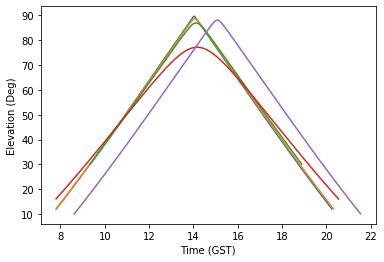

In [18]:
fig, axes = plt.subplots()

for ant in antennas:
    gsts = ant.upTimes(RA, Dec, step)
    times = [rad2hour(x) for x in gsts]
    
    (Az, El) = ant.calcAzEl(RA, Dec, gsts)
    degEl = [rad2deg(x) for x in El]
    axes.plot(times, degEl)

axes.set_xlabel('Time (GST)')
axes.set_ylabel('Elevation (Deg)');

### Calculate Baseline UV coordinates

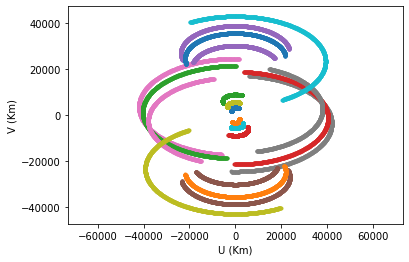

In [19]:
fig, axes = plt.subplots()

for b in baselines:
    b.calcUp(RA, Dec, step)
    b.UVtrack(RA, Dec, b.gst, wavelength) 
    u = b.u
    v = b.v
    axes.plot(-u/1000, v/1000, '.', u/1000, -v/1000, '.')
    
axes.set_xlabel('U (Km)')
axes.set_ylabel('V (Km)');
axes.axis('equal');


### Baseline Sensitivity

In [602]:
for b in baselines:
    print('{0} {1:.2f} mJy'.format(b.name, b.sensitivity(bandwidth,calInt,True)*1e3))

ATCA->Mopra 1.68 mJy
ATCA->Parkes 0.53 mJy
ATCA->Hobart 1.92 mJy
ATCA->Ceduna 1.98 mJy
Mopra->Parkes 1.76 mJy
Mopra->Hobart 6.36 mJy
Mopra->Ceduna 6.59 mJy
Parkes->Hobart 2.01 mJy
Parkes->Ceduna 2.08 mJy
Hobart->Ceduna 7.52 mJy


In [23]:
def TestIt(name, SEFD, location=[]):
            
        print("Location: ", len(location))
        print("Name= ", name)
        print("SEFD: ", SEFD)
        
TestIt("ATCA",  100, [10,20])

Location:  2
Name=  ATCA
SEFD:  100


In [11]:
Telescope("ATCA",149.57,-30.31,12,39)


TypeError: __init__() takes 5 positional arguments but 6 were given